In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import Audio

In [170]:
sample_rt, clean_data = read('clean.wav')
sample_rt, noisy_data = read('noisy.wav')
sample_rt, noise_data = read('noise.wav')
sample_rt

16000

In [ ]:
clean_data.shape

(50000,)

In [ ]:
Audio("noisy.wav", rate=16000)

#Plotting the audio files

In [ ]:
def plot_audio(sr,audio_data):
    # sr, audio_data = read(audio_file)
    data_size = len(audio_data)
    plt.figure(figsize=(20,3))
    plt.plot(audio_data)
    plt.xticks(np.arange(0,data_size,sr),
            np.arange(0,data_size/sr,1))
    plt.ylabel("Amplitude")
    plt.xlabel("Time (sr,second)")
    plt.title("The total length of time series = {} sec, sample_rate = {}".format(data_size/sr, sr))
    plt.show()

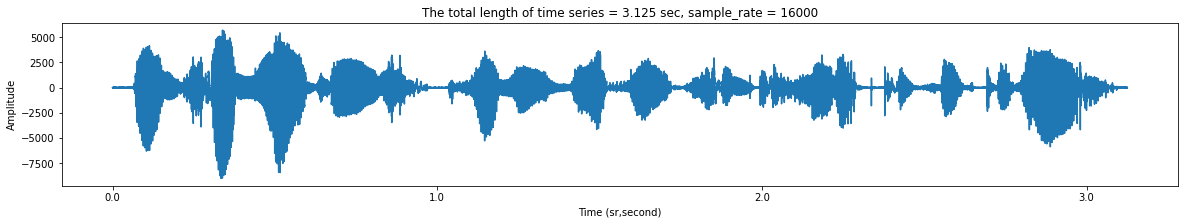

In [ ]:
plot_audio(sample_rt, clean_data)

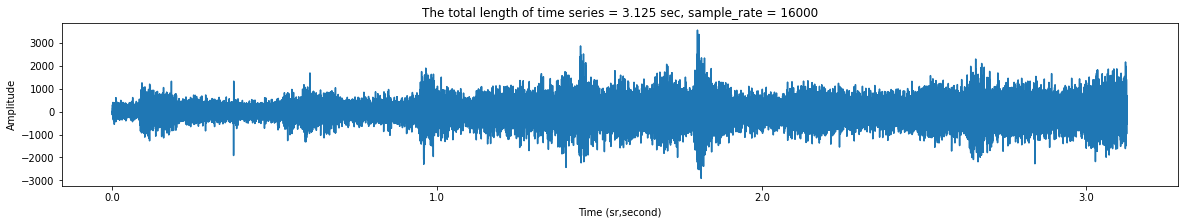

In [ ]:
plot_audio(sample_rt, noise_data)

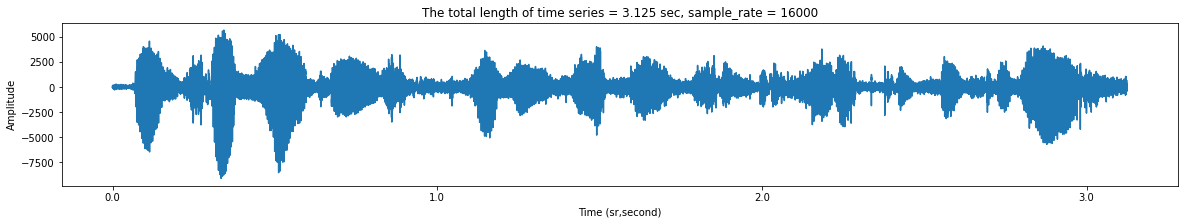

In [ ]:
plot_audio(sample_rt, noisy_data)

## Spectogram function

In [118]:
'''
 window length = 25ms * 16000 = 400
 hop length = 16*10^3 * 10ms = 160
 magnitude of fft = 256
'''
def spectrogram(aud_data, mag_fft=256, window_len=400, hop_len=160):
    
    # calculate number of frames
    nof_frames = 1 + np.int(np.floor((len(aud_data) - window_len) / float(hop_len)))  ## +1 for padding
    spect = np.zeros((nof_frames, 256), np.complex64)

    # perform sliding window operation
    for i in range(nof_frames):
        sliding_win = aud_data[i * hop_len: i * hop_len + window_len] * np.hamming(window_len)
        spect[i] = np.fft.fft(sliding_win, n=mag_fft)

    # get the log of the absolute features values
    spect = np.log(np.abs(spect[:, :(mag_fft) // 2]))
    return spect

## whitening function

In [109]:
def whitening(normalize_data):
    # SVD decomposition
    U, S, V = np.linalg.svd(normalize_data, full_matrices=True)
    # find whitening matrix W
    wt_mat = V.T / S * np.sqrt(normalize_data.shape[0] - 1)
    return wt_mat

In [110]:
def whitening_transform(clean_spect, noisy_spect):
    # omputing whtening from clean file
    w_mat = whitening(clean_spect)

    #to apply whitening transformation 
    #perform matrix multiplication between whitening matrix and clean/noisy matrix
    return clean_spect @ w_mat, noisy_spect @ w_mat

## Spectogram of clean and noise file

In [119]:
clean_spectogram = spectrogram(clean_data)
noise_spectogram = spectrogram(noise_data)

In [120]:
clean_spectogram.shape

(311, 128)

### Standarize the data

In [121]:
mean = clean_spectogram.mean(axis=0)
std = clean_spectogram.std(axis=0)

clean_spectogram = (clean_spectogram - mean) / std
noise_spectogram = (noise_spectogram - mean) / std

## Whitening transformation

In [122]:
whitten_clean, whitten_noise = whitening_transform(clean_spectogram, noise_spectogram)

## Find the absolute value of the non-diagonal entries of the sampled covariance matrix the “whitenned” clean and noisy speech features

In [123]:
def abs_whitten_data(whitten_data):
    # Sampled covarience matrices
    wt_cov = np.cov(whitten_data.T)
    # Average of non-diag entries
    return np.mean(np.abs(wt_cov - (np.diag(wt_cov))))


In [124]:
absClean_wt = abs_whitten_data(whitten_clean.T)
absNoise_wt = abs_whitten_data(whitten_noise.T)
absClean_wt, absNoise_wt

(0.9967846137564919, 7.1931465905351315)

## For noisy file

In [125]:
# Spectogram
noisy_spectogram = spectrogram(noisy_data)

In [126]:
noisy_spectogram = (noisy_spectogram - mean)

## Whitening transformation

In [127]:
whitten_clean, whitten_noisy = whitening_transform(clean_spectogram, noisy_spectogram)

In [128]:
absNoisy_wt = abs_whitten_data(whitten_noisy.T)

In [129]:
absClean_wt, absNoisy_wt

(0.9967846137564919, 14.276187747069299)

In [157]:
clean_cov = np.cov(clean_spectogram.T)
whitten_clean_cov = np.cov(whitten_clean.T)

# noisy_spec_cov = np.cov(noisy_spectogram.T)
# noisy_spec_white_cov = np.cov(noisy_spec_white.T)

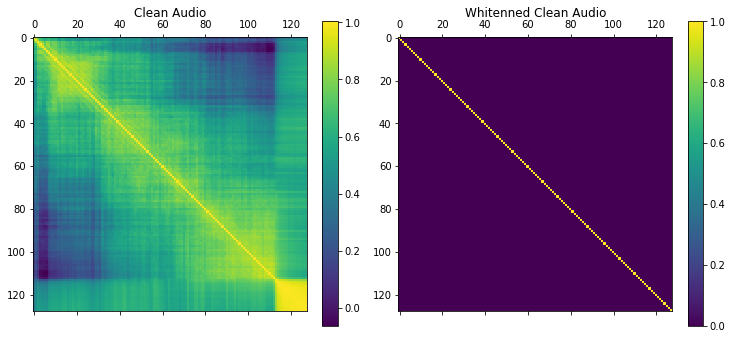

In [169]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,9))
f1 = ax[0].matshow(clean_cov)
f2 = ax[1].matshow(whitten_clean_cov)
ax[0].set_title('Clean Audio')
ax[1].set_title('Whitenned Clean Audio')
fig.colorbar(f1, ax=ax[0], fraction=0.05)
fig.colorbar(f2, ax=ax[1], fraction=0.05)